In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
import time

/home/sam/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#read 1st row modified database of SMS

data0 = pd.read_csv('/home/sam/Documents/spam.csv',encoding = "ISO-8859-1",dtype=str)
#original database at https://archive.ics.uci.edu/dataset/228/sms+spam+collection
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   SMS     5572 non-null   object
 2   s1      50 non-null     object
 3   s2      12 non-null     object
 4   s3      6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
data0.head()

,label,SMS,s1,s2,s3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [17]:
#getting rid of the nan values, labeling spam as 1 and ham as 0 and adding acolumn for SMS text length

data0.dropna(axis='columns',inplace=True) 
data0["label1"]=data0["label"].map({'spam': 1.0, 'ham': 0.0})
data0["Text_size"]=data0["SMS"].str.len()
data0.head()

,label,SMS,label1,Text_size
0,ham,"Go until jurong point, crazy.. Available only ...",0.0,111
1,ham,Ok lar... Joking wif u oni...,0.0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1.0,155
3,ham,U dun say so early hor... U c already then say...,0.0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0.0,61


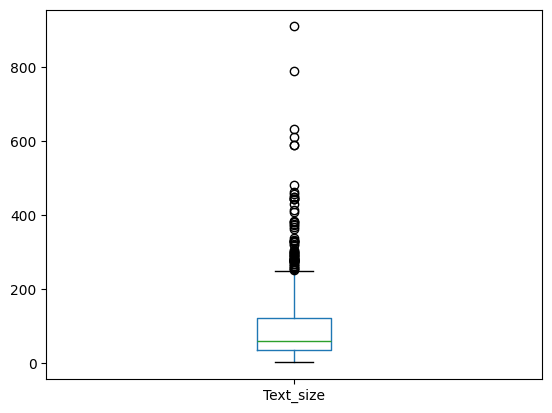

In [18]:
#detect outliers with boxplot
data0.boxplot(column="Text_size",grid=False)
plt.show()

Percentage of values with text size greater than 250: 0.01%
Number of values with text size greater than 250: 68


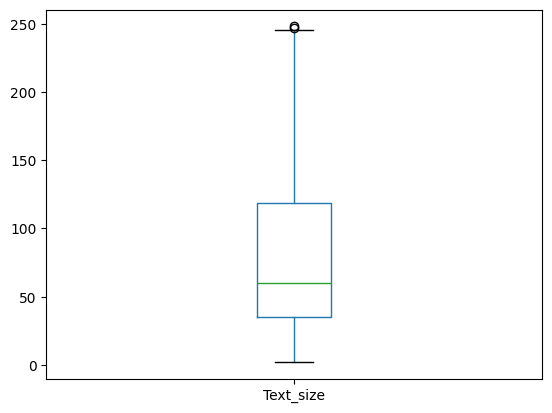

In [19]:
#create new database for input with text size less than 250
data1=data0[data0["Text_size"]<=250]
print('Percentage of values with text size greater than 250: '+str(round(len(data0[data0["Text_size"]>250])/len(data0),2))+'%')
print('Number of values with text size greater than 250: '+str(len(data0[data0["Text_size"]>250])))
data1.boxplot(column="Text_size",grid=False)
plt.show()

In [8]:
#Using transformers library to tokenize the text

padtkn=max(data1.Text_size) #padding number to have all tensors of the same length
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
encodedinp=tokenizer(data1.SMS.tolist(),padding=True,truncation=True,max_length=padtkn,return_tensors='pt')

In [20]:
#creating database for the KAN model to read with sklearn 

x=encodedinp['input_ids']
x=torch.tensor(x,dtype=torch.float32)
y=data1.label1.tolist()
y=torch.tensor(y,dtype=torch.float32).reshape(len(y),1)

xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size =.1, random_state = 42)
data={'train_input':xtrain,'test_input':xtest,'train_label':ytrain,'test_label':ytest}
print(xtrain[0])
print('Size of each input vector: '+str(len(xtrain[0])))
print('Size of train data: '+str(len(xtrain)))
print('Size of test data: '+str(len(xtest)))

tensor([ 101., 4403., 1177., 1184., 1116., 1103., 2197., 1142., 2068.,  136.,
         102.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.])
Size of each input vector: 114
Size of train data: 4953
Size of test data: 551


/tmp/ipykernel_5867/797478831.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float32)


In [37]:
#creating model and setting up hyperparameters
nr = 80
n_epochs = 350
batch_size = 30
lr = 0.0001

model = nn.Sequential(
    nn.Linear(114,nr),
    nn.Sigmoid(),
    nn.Linear(nr,nr),
    nn.Sigmoid(),
    nn.Linear(nr,1),
    nn.Sigmoid())

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [38]:
start=time.time()
c0=0
for epoch in range(n_epochs):
    for i in range(0,len(xtrain),batch_size):
        xbatch = xtrain[i:i+batch_size]
        ybatch = ytrain[i:i+batch_size]
        y_model = model(xbatch)
        loss = loss_fn(y_model,ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch} ({prci} %), latest loss {loss}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

Finished epoch 34 (10 %), latest loss 0.574434757232666
Finished epoch 69 (20 %), latest loss 0.5091127753257751
Finished epoch 104 (30 %), latest loss 0.3432939052581787
Finished epoch 139 (40 %), latest loss 0.18290270864963531
Finished epoch 174 (50 %), latest loss 0.12402918189764023
Finished epoch 209 (60 %), latest loss 0.18697698414325714
Finished epoch 244 (70 %), latest loss 0.14330728352069855
Finished epoch 279 (80 %), latest loss 0.0989537164568901
Finished epoch 314 (90 %), latest loss 0.14230132102966309
Finished epoch 349 (100 %), latest loss 0.059828806668519974
Total time: 0.8 min


In [39]:
yn = model(xtest)
accuracy = (yn.round() == ytest).float().mean()
print(f'Accuracy: {accuracy}')

Accuracy: 0.8983666300773621
